In [94]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from itertools import product
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [95]:
# Data Loading
data_train = pd.read_csv('Google_Stock_Price_Train.csv')
data_test = pd.read_csv('Google_Stock_Price_Test.csv')

print(data_train.head())

# Converting string data to float
features = ['Open', 'High', 'Low', 'Close', 'Volume']
for feature in features:
    if data_train[feature].dtype == 'object':
        data_train[feature] = data_train[feature].str.replace(',', '').astype(float)
    if data_test[feature].dtype == 'object':
        data_test[feature] = data_test[feature].str.replace(',', '').astype(float)
print(data_train.head())


       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7380500.0
1  1/4/2012  331.27  333.87  329.08  666.45   5749400.0
2  1/5/2012  329.83  330.75  326.89  657.21   6590300.0
3  1/6/2012  328.34  328.77  323.68  648.24   5405900.0
4  1/9/2012  322.04  322.29  309.46  620.76  11688800.0


In [96]:
# Data Normalization
scaler = MinMaxScaler()
data_train_scaled = scaler.fit_transform(data_train[features])
data_test_scaled = scaler.transform(data_test[features])
print(data_train_scaled)

[[0.08581368 0.09640129 0.09044931 0.23757287 0.29525831]
 [0.09701243 0.09834351 0.09823458 0.24151427 0.22993592]
 [0.09433366 0.09251685 0.09408623 0.22878051 0.26361233]
 ...
 [0.95725128 0.95807422 0.95844067 0.40495845 0.04589107]
 [0.93796041 0.94257381 0.95033338 0.40184391 0.02949139]
 [0.93688146 0.93669113 0.93421352 0.38672602 0.07056868]]


In [97]:
N = 15  # Number of past days to use
M = 3   # Number of future days to predict

# Creating sequences
X_train, y_train = [], []
for i in range(N, len(data_train_scaled) - M + 1):
    X_train.append(data_train_scaled[i-N:i])
    y_train.append(data_train_scaled[i:i+M, :])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(N, len(data_test_scaled) - M + 1):
    X_test.append(data_test_scaled[i-N:i])
    y_test.append(data_test_scaled[i:i+M, :])
X_test, y_test = np.array(X_test), np.array(y_test)

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Converting to PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

X_train, y_train = torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device)

Using device: cuda


In [98]:
# Defining the models
class StockPriceRNN(nn.Module):
    def __init__(self, input_size, output_size, future_steps, dropout=0.1, hidden_size=50, num_layers=2):
        super(StockPriceRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size * future_steps)
        self.future_steps = future_steps

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :] 
        out = self.fc(out)
        return out.view(-1, self.future_steps, 5)

class StockPriceGRU(nn.Module):
    def __init__(self, input_size, output_size, future_steps, dropout = 0.1, hidden_size=50, num_layers=2):
        super(StockPriceGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size * future_steps)
        self.future_steps = future_steps

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.view(-1, self.future_steps, 5)

class StockPriceLSTM(nn.Module):
    def __init__(self, input_size, output_size, future_steps, dropout=0.1, hidden_size=50, num_layers=2):
        super(StockPriceLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size * future_steps)
        self.future_steps = future_steps

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.view(-1, self.future_steps, 5)

In [99]:
# Function to train the model
def train_model(model, train_loader, val_loader, optimizer_class, lr=0.001, epochs=100, device='cpu'):
    criterion = nn.MSELoss()
    optimizer = optimizer_class(model.parameters(), lr=lr)
    
    all_train_losses = []
    all_val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            
        avg_train_loss = running_loss / len(train_loader.dataset)
        all_train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                val_outputs = model(X_batch)
                val_loss += criterion(val_outputs, y_batch).item() * X_batch.size(0)
        
        avg_val_loss = val_loss / len(val_loader.dataset)
        all_val_losses.append(avg_val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    return model, all_train_losses, all_val_losses

In [100]:
# Function to evaluate the model on test data
def evaluate_model(model, test_loader):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            outputs_flat = outputs.view(-1, 5)
            y_batch_flat = y_batch.view(-1, 5)
            
            all_outputs.append(outputs_flat.detach().cpu().numpy())
            all_targets.append(y_batch_flat.detach().cpu().numpy())
            
            batch_loss = mean_squared_error(y_batch_flat.cpu().numpy(), outputs_flat.cpu().numpy())
            total_loss += batch_loss * X_batch.size(0)
            total_samples += X_batch.size(0)

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    rmse = np.sqrt(mean_squared_error(all_targets, all_outputs))
    return rmse

In [ ]:
# Comparing the models with different hyperparameters
def compare_models(X_train, y_train, X_val, y_val, X_test, y_test, M, device='cpu'):
    models = [StockPriceRNN, StockPriceLSTM, StockPriceGRU]
    learning_rates = [0.001, 0.005, 0.01]
    optimizers = [optim.Adam, optim.SGD]
    batch_sizes = [16, 32, 64]
    num_layers = [2, 3]
    hidden_sizes = [50, 100]
    epochs = 150

    combinations = list(product(models, learning_rates, optimizers, batch_sizes, num_layers, hidden_sizes))
    results = []
    best_model_config = None
    best_model_instance = None
    best_rmse = float('inf')

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)
    
    for model_class, lr, optimizer, batch_size, num_layer, hidden_size in combinations:
        print(f"\nTraining {model_class.__name__} with lr={lr}, optimizer={optimizer.__name__}, batch-size={batch_size}, layers={num_layer}, and hidden-size={hidden_size}")
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        model = model_class(input_size=5,
                            output_size=5,
                            future_steps=M,
                            num_layers=num_layer,
                            hidden_size=hidden_size).to(device)

        trained_model, train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, lr=lr, epochs=epochs, device=device)
        rmse = evaluate_model(trained_model, test_loader)
        
        results.append({
            'Model': model_class.__name__,
            'Learning Rate': lr,
            'Optimizer': optimizer.__name__,
            'RMSE': rmse,
            'Train Losses': train_losses,
            'Validation Losses': val_losses,
            'Batch Size': batch_size,
            'Number of Layers': num_layer,
            'Hidden Size': hidden_size
        })
        print(f"Test RMSE: {rmse:.4f}")
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_model_config = {
                'Model': model_class.__name__,
                'Learning Rate': lr,
                'Optimizer': optimizer.__name__,
                'RMSE': rmse,
                'Train Losses': train_losses,
                'Validation Losses': val_losses,
                'Batch Size': batch_size,
                'Number of Layers': num_layer,
                'Hidden Size': hidden_size
            }
            best_model_instance = trained_model

    results_df = pd.DataFrame(results)
    print("\nExperiment Results:")
    print(results_df)

    print("\nBest Model Configuration:")
    print(best_model_config)
    
    return best_model_instance, best_model_config, results_df

In [102]:
best_model, best_model_config, results_df = compare_models(X_train, y_train, X_val, y_val, X_test, y_test, M, device=device)


Training StockPriceRNN with lr=0.001, optimizer=Adam, batch-size=16, layers=2, and hidden-size=50
Epoch [10/150], Train Loss: 0.0021, Val Loss: 0.0021
Epoch [20/150], Train Loss: 0.0018, Val Loss: 0.0018
Epoch [30/150], Train Loss: 0.0017, Val Loss: 0.0018
Epoch [40/150], Train Loss: 0.0017, Val Loss: 0.0019
Epoch [50/150], Train Loss: 0.0016, Val Loss: 0.0017
Epoch [60/150], Train Loss: 0.0016, Val Loss: 0.0017
Epoch [70/150], Train Loss: 0.0015, Val Loss: 0.0017
Epoch [80/150], Train Loss: 0.0016, Val Loss: 0.0018
Epoch [90/150], Train Loss: 0.0015, Val Loss: 0.0018
Epoch [100/150], Train Loss: 0.0015, Val Loss: 0.0017
Epoch [110/150], Train Loss: 0.0015, Val Loss: 0.0017
Epoch [120/150], Train Loss: 0.0015, Val Loss: 0.0017
Epoch [130/150], Train Loss: 0.0015, Val Loss: 0.0017
Epoch [140/150], Train Loss: 0.0015, Val Loss: 0.0017
Epoch [150/150], Train Loss: 0.0015, Val Loss: 0.0017
Test RMSE: 0.0407

Training StockPriceRNN with lr=0.001, optimizer=Adam, batch-size=16, layers=2, an

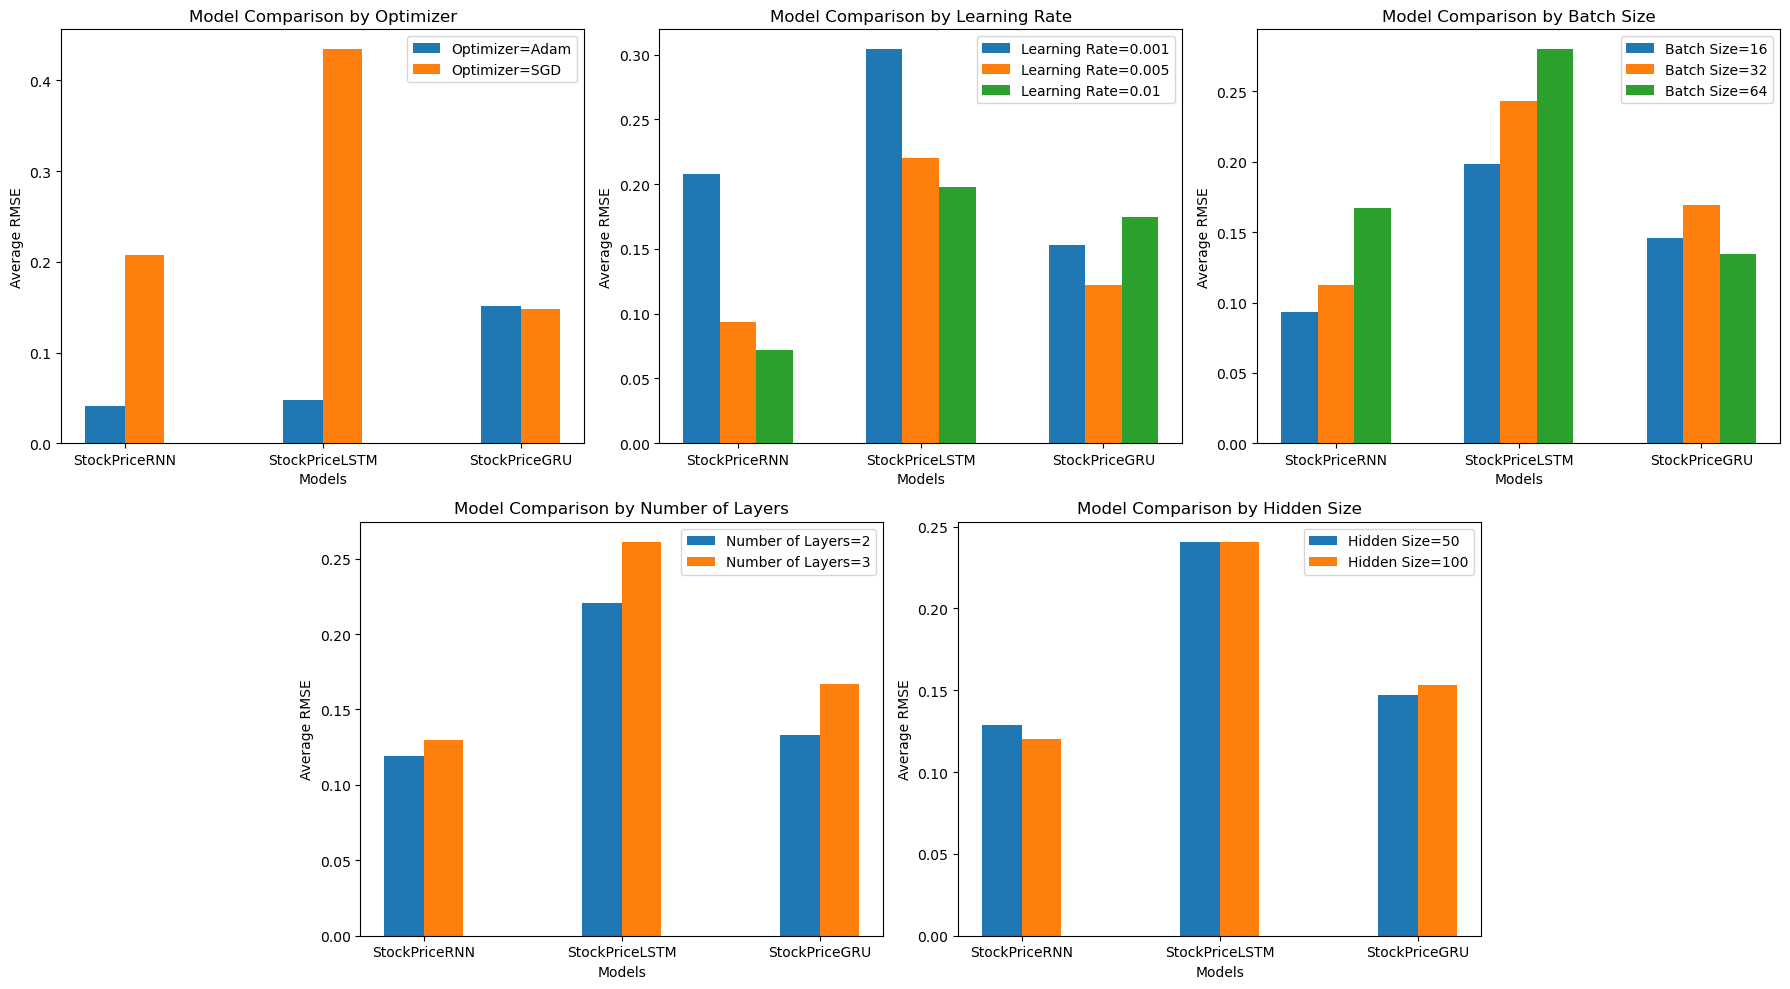

In [131]:
# Plotting bar charts for the comparison of the models
def plot_rmse(ax, column_name, values, title, results_df, models, bar_width, index_offset=0):
    index = np.arange(len(models))  # Define index inside the function
    for i, val in enumerate(values):
        grouped_data = results_df[results_df[column_name] == val].groupby('Model')['RMSE'].mean().reset_index()
        rmse_values = grouped_data['RMSE'].values
        ax.bar(index + i * bar_width + index_offset, rmse_values, bar_width, label=f'{column_name}={val}')

    ax.set_xlabel('Models')
    ax.set_ylabel('Average RMSE')
    ax.set_title(title)
    ax.set_xticks(index + bar_width * (len(values) - 1) / 2 + index_offset)
    ax.set_xticklabels(models)
    ax.legend()

def plot_bar_charts(results_df):
    models = results_df['Model'].unique()
    learning_rates = results_df['Learning Rate'].unique()
    optimizers = results_df['Optimizer'].unique()
    batch_sizes = results_df['Batch Size'].unique()
    num_layers = results_df['Number of Layers'].unique()
    hidden_sizes = results_df['Hidden Size'].unique()

    fig = plt.figure(figsize=(18, 10))
    ax1 = plt.subplot2grid((2, 6), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((2, 6), (0, 2), colspan=2)
    ax3 = plt.subplot2grid((2, 6), (0, 4), colspan=2)
    ax4 = plt.subplot2grid((2, 6), (1, 1), colspan=2)
    ax5 = plt.subplot2grid((2, 6), (1, 3), colspan=2)
    axes = [ax1, ax2, ax3, ax4, ax5]
    bar_width = 0.2

    plot_rmse(axes[0], 'Optimizer', optimizers, 'Model Comparison by Optimizer', results_df, models, bar_width)
    plot_rmse(axes[1], 'Learning Rate', learning_rates, 'Model Comparison by Learning Rate', results_df, models, bar_width, index_offset=bar_width * len(optimizers))
    plot_rmse(axes[2], 'Batch Size', batch_sizes, 'Model Comparison by Batch Size', results_df, models, bar_width, index_offset=bar_width * (len(optimizers) + len(learning_rates)))
    plot_rmse(axes[3], 'Number of Layers', num_layers, 'Model Comparison by Number of Layers', results_df, models, bar_width, index_offset=bar_width * (len(optimizers) + len(learning_rates) + len(batch_sizes)))
    plot_rmse(axes[4], 'Hidden Size', hidden_sizes, 'Model Comparison by Hidden Size', results_df, models, bar_width, index_offset=bar_width * (len(optimizers) + len(learning_rates) + len(batch_sizes) + len(num_layers)))
    plt.tight_layout()
    plt.show()

plot_bar_charts(results_df)

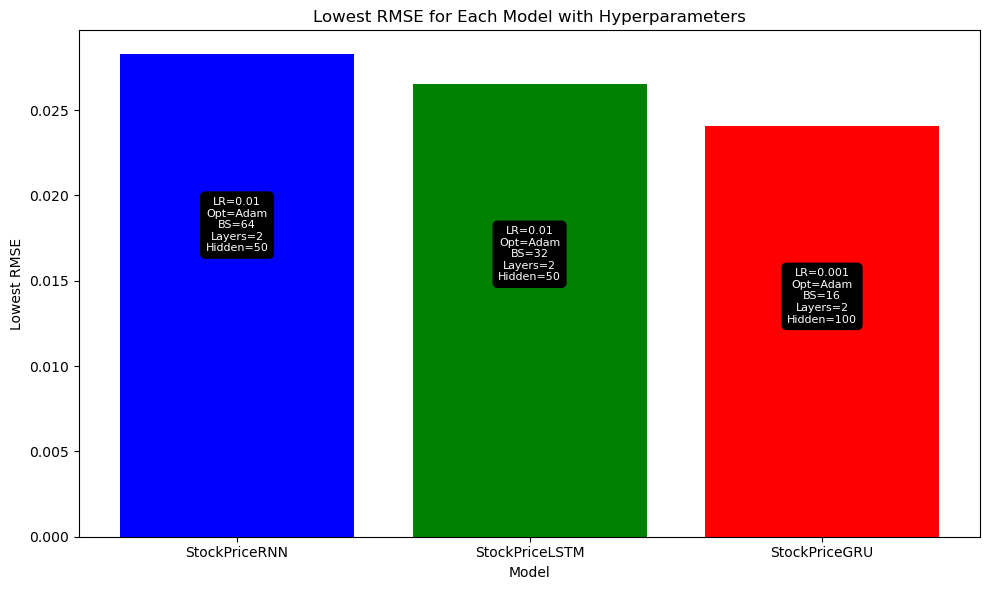

In [ ]:
# Plotting the lowest RMSE for each model with hyperparameters
def plot_lowest_rmse_for_models(results_df):
    lowest_rmse_data = []

    for model in results_df['Model'].unique():
        model_data = results_df[results_df['Model'] == model]
        best_row = model_data.loc[model_data['RMSE'].idxmin()]
        lowest_rmse = best_row['RMSE']
        learning_rate = best_row['Learning Rate']
        optimizer = best_row['Optimizer']
        batch_size = best_row['Batch Size']
        num_layers = best_row['Number of Layers']
        hidden_size = best_row['Hidden Size']
        
        lowest_rmse_data.append({
            'Model': model,
            'Lowest RMSE': lowest_rmse,
            'Learning Rate': learning_rate,
            'Optimizer': optimizer,
            'Batch Size': batch_size,
            'Num Layers': num_layers,
            'Hidden Size': hidden_size
        })
    
    lowest_rmse_df = pd.DataFrame(lowest_rmse_data)
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(lowest_rmse_df['Model'], lowest_rmse_df['Lowest RMSE'], color=['blue', 'green', 'red'])
    
    for i, (bar, row) in enumerate(zip(bars, lowest_rmse_df.iterrows())):
        _, row = row
        text = f"LR={row['Learning Rate']}\nOpt={row['Optimizer']}\nBS={row['Batch Size']}\nLayers={row['Num Layers']}\nHidden={row['Hidden Size']}"
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.01,
                text, ha='center', va='center', fontsize=8, color='white', 
                bbox=dict(facecolor='black', edgecolor='none', boxstyle='round,pad=0.5'))
    
    ax.set_xlabel('Model')
    ax.set_ylabel('Lowest RMSE')
    ax.set_title('Lowest RMSE for Each Model with Hyperparameters')
    plt.tight_layout()
    plt.show()

plot_lowest_rmse_for_models(results_df)

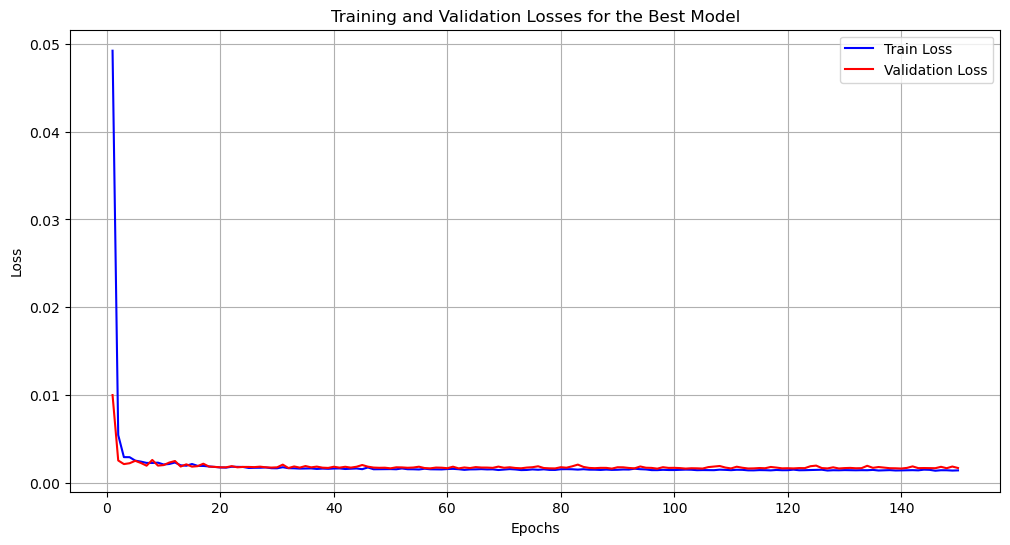

In [132]:
# Plotting the train and validation losses
train_losses = results_df['Train Losses'].iloc[0]
val_losses = results_df['Validation Losses'].iloc[0]

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Losses for the Best Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

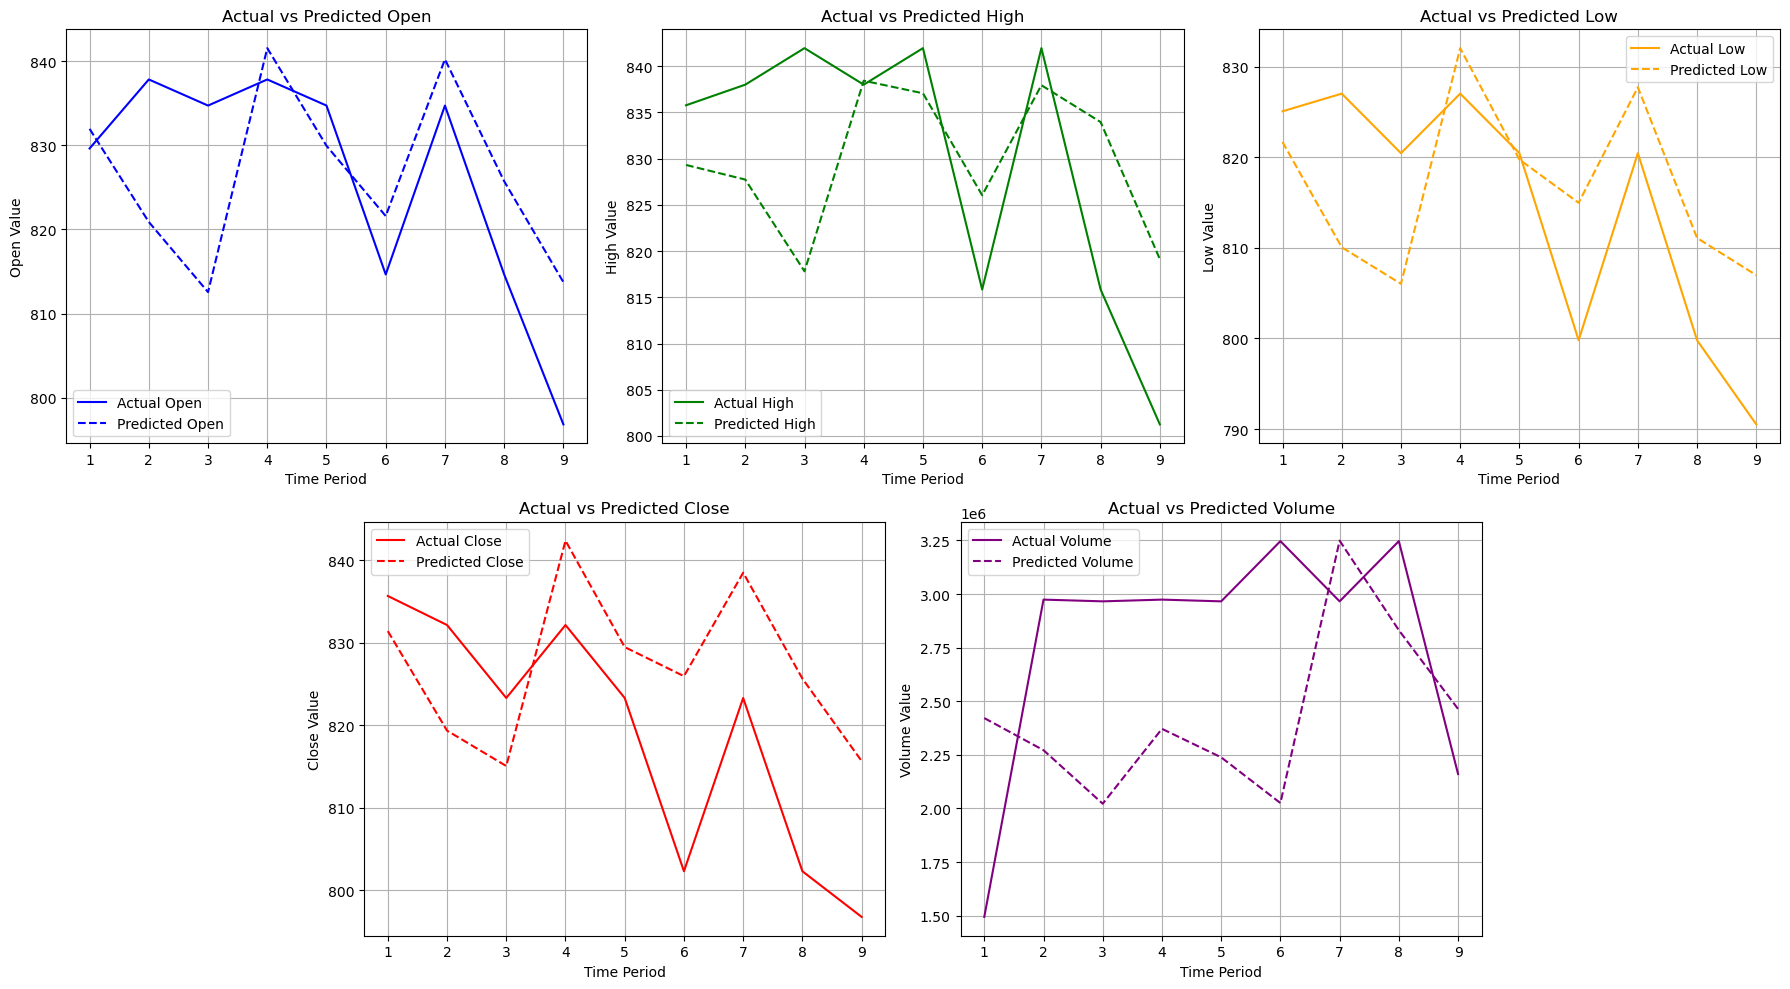

In [133]:
# Plotting the actual vs predicted values for all features on best model
def plot_feature(ax, feature, color, time_steps, y_test_rescaled, predictions_rescaled):
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    feature_index = features.index(feature)
    ax.plot(time_steps, y_test_rescaled[:, feature_index], label=f'Actual {feature}', color=color)
    ax.plot(time_steps, predictions_rescaled[:, feature_index], label=f'Predicted {feature}', color=color, linestyle='--')
    ax.set_title(f'Actual vs Predicted {feature}')
    ax.set_xlabel('Time Period')
    ax.set_ylabel(f'{feature} Value')
    ax.legend()
    ax.grid(True)

def plot_actual_vs_predicted(best_model, X_test, y_test, M, scaler, device):
    best_model.eval()
    with torch.no_grad():
        predictions = best_model(X_test)

    predictions_flat = predictions.view(-1, 5).detach().cpu().numpy()
    y_test_flat = y_test.view(-1, 5).detach().cpu().numpy()
    predictions_rescaled = scaler.inverse_transform(predictions_flat)
    y_test_rescaled = scaler.inverse_transform(y_test_flat)
    time_steps = np.arange(1, len(y_test_rescaled) + 1)

    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    colors = ['blue', 'green', 'orange', 'red', 'purple']
    fig = plt.figure(figsize=(18, 10))
    ax1 = plt.subplot2grid((2, 6), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((2, 6), (0, 2), colspan=2)
    ax3 = plt.subplot2grid((2, 6), (0, 4), colspan=2)
    ax4 = plt.subplot2grid((2, 6), (1, 1), colspan=2)
    ax5 = plt.subplot2grid((2, 6), (1, 3), colspan=2)
    axes = [ax1, ax2, ax3, ax4, ax5]

    plot_feature(axes[0], 'Open', 'blue', time_steps, y_test_rescaled, predictions_rescaled)
    plot_feature(axes[1], 'High', 'green', time_steps, y_test_rescaled, predictions_rescaled)
    plot_feature(axes[2], 'Low', 'orange', time_steps, y_test_rescaled, predictions_rescaled)
    plot_feature(axes[3], 'Close', 'red', time_steps, y_test_rescaled, predictions_rescaled)
    plot_feature(axes[4], 'Volume', 'purple', time_steps, y_test_rescaled, predictions_rescaled)
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(best_model, X_test, y_test, M, scaler, device)

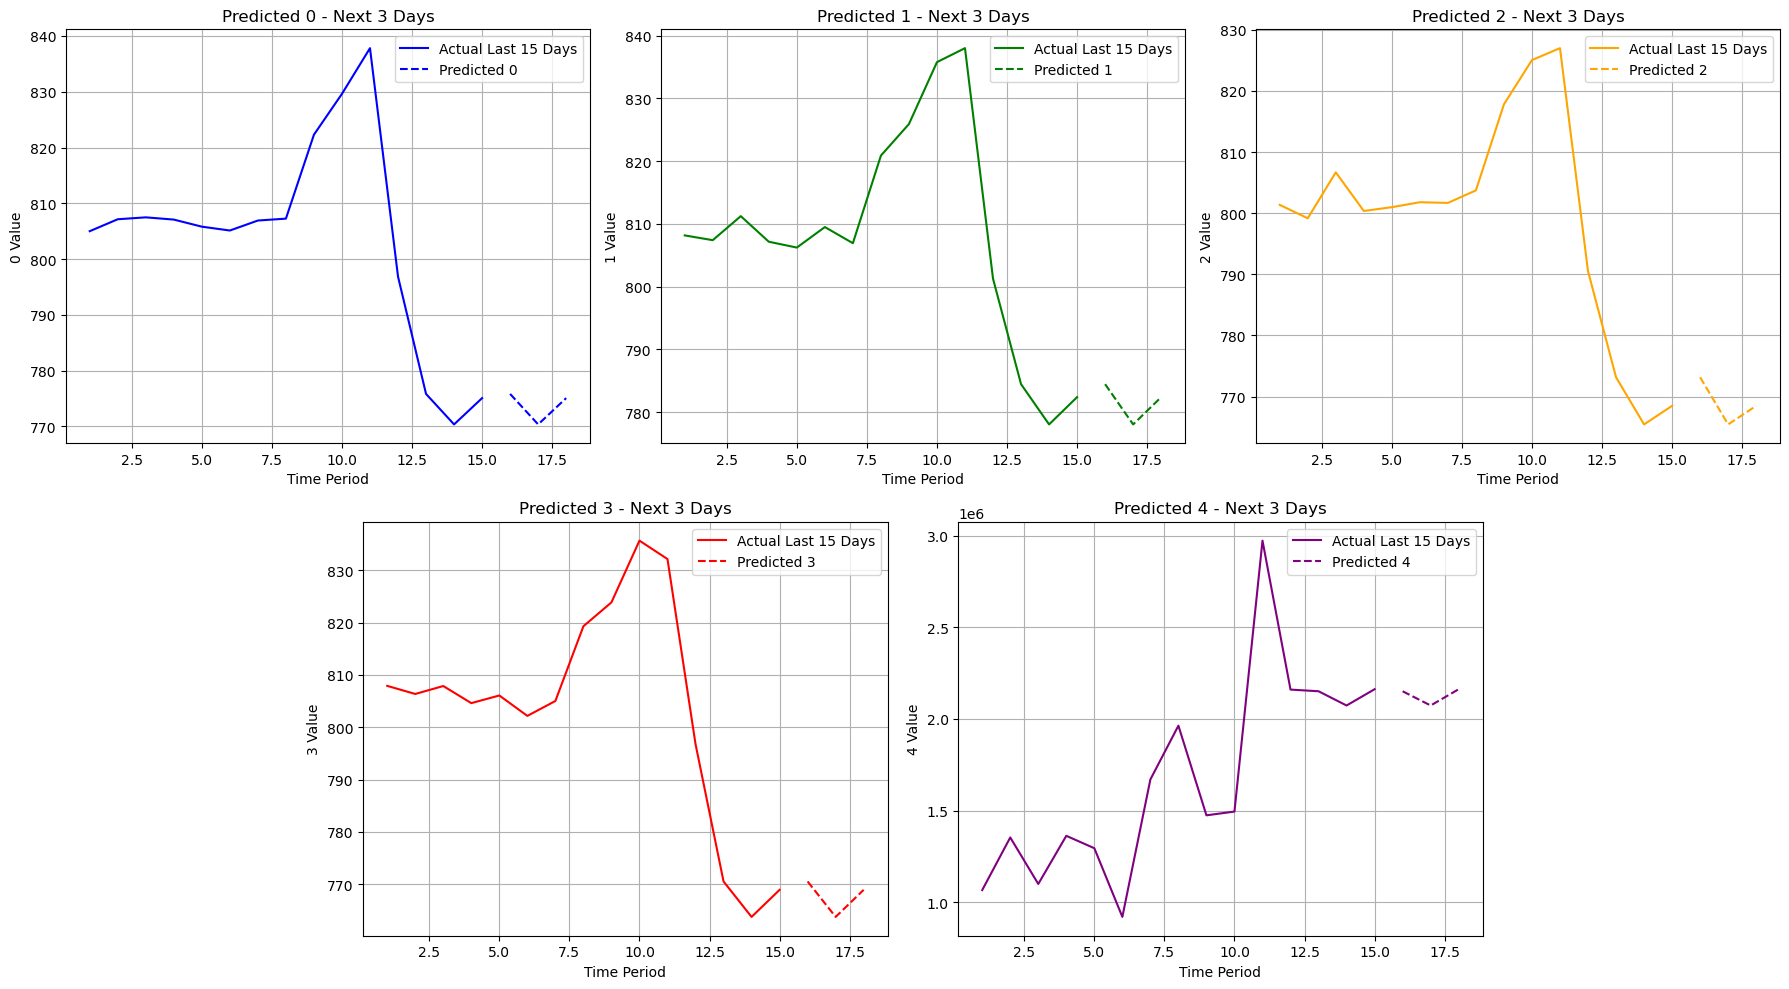

In [134]:
# Predict and plot next M days
def plot_feature(ax, time_steps, actual_data, predictions_rescaled, feature, color, N, M):
    ax.plot(time_steps[:N], actual_data[:, feature], label=f'Actual Last {N} Days', color=color)
    ax.plot(time_steps[N:], predictions_rescaled[:, feature], label=f'Predicted {feature}', color=color, linestyle='--')
    ax.set_title(f'Predicted {feature} - Next {M} Days')
    ax.set_xlabel('Time Period')
    ax.set_ylabel(f'{feature} Value')
    ax.legend()
    ax.grid(True)

def predict_and_plot_future(model, X_test, y_test, M, scaler, device, N):
    last_X_data = X_test[-1, -N + 1:, :]
    last_y_data = y_test[-1, -1]
    combined_input = torch.cat((last_X_data.unsqueeze(0), last_y_data.unsqueeze(0).unsqueeze(0)), dim=1)

    model.eval()
    predictions = []
    with torch.no_grad():
        for _ in range(M):
            pred = model(combined_input)
            predictions.append(pred[0, -1, :].cpu().numpy())
            combined_input = torch.cat((combined_input[:, 1:, :], pred[:, -1:, :]), dim=1)

    predictions = np.array(predictions)
    predictions_rescaled = scaler.inverse_transform(predictions)
    time_steps = np.arange(1, len(combined_input[0]) + M + 1)
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    colors = ['blue', 'green', 'orange', 'red', 'purple']

    fig = plt.figure(figsize=(18, 10))
    ax1 = plt.subplot2grid((2, 6), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((2, 6), (0, 2), colspan=2)
    ax3 = plt.subplot2grid((2, 6), (0, 4), colspan=2)
    ax4 = plt.subplot2grid((2, 6), (1, 1), colspan=2)
    ax5 = plt.subplot2grid((2, 6), (1, 3), colspan=2)
    axes = [ax1, ax2, ax3, ax4, ax5]
    actual_data = scaler.inverse_transform(combined_input.view(-1, 5).detach().cpu().numpy())

    plot_feature(axes[0], time_steps, actual_data, predictions_rescaled, 0, 'blue', N, M)
    plot_feature(axes[1], time_steps, actual_data, predictions_rescaled, 1, 'green', N, M)
    plot_feature(axes[2], time_steps, actual_data, predictions_rescaled, 2, 'orange', N, M)
    plot_feature(axes[3], time_steps, actual_data, predictions_rescaled, 3, 'red', N, M)
    plot_feature(axes[4], time_steps, actual_data, predictions_rescaled, 4, 'purple', N, M)
    plt.tight_layout()
    plt.show()

future_predictions = predict_and_plot_future(best_model, X_test, y_test, M, scaler, device, N)